In [9]:
import pandas as pd
import fitter
import dill
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt

In [10]:
def get_auswanderung():
    df = pd.read_excel("je-d-01.05.04.01.01.xlsx", sheet_name="Auswanderungen", header=2, nrows=49)

    df.set_index(df.columns[0], drop=True, inplace=True)
    df.index.name = ""

    df = df.transpose()

    df = df[["Total", "Schweizer", "Deutschland", "Österreich", "Frankreich", "Italien"]]

    df["Deutsch"] = df[["Schweizer", "Deutschland", "Österreich"]].sum(axis=1)
    df.drop(["Schweizer", "Deutschland", "Österreich"], axis=1, inplace=True)

    df["Andere"] = df["Total"] - df["Frankreich"] - df["Italien"] - df["Deutsch"]

    df.drop("Total", inplace=True, axis=1)

    df.columns = ["Französisch", "Italienisch", "Deutsch", "Andere"]

    df = df.transpose()

    df = df.apply(pd.to_numeric, errors="coerce")

    return df

get_auswanderung()

,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,...,2011 1,2012,2013,2014,2015,2016,2017,2018,2019,2020
Französisch,4299,4354,4086,3705,3942,3958,3710,3603,3963,3988,...,5889,6263,6177,6658,7469,7863,8124,9041,8645,7419
Italienisch,12257,16109,12242,10370,10399,11363,10405,9092,9182,8163,...,5266,5575,5929,6957,7938,8947,9570,9890,9458,8064
Deutsch,39305,39899,36703,37490,38299,39165,37906,37574,36226,37774,...,46345,48100,46183,46707,48263,47967,48532,48228,47163,39529
Andere,47472,56672,51994,47740,46869,48912,46500,44509,42433,40153,...,38994,43943,47907,50781,52961,55876,58771,63066,60955,54364


In [11]:
def display_distributions_cdf(f:fitter.Fitter, data:list, plotName:str, cost_method:str):
    best_distributions_names = f.summary(plot=False, method=cost_method).index.values[:6]

    sorted_data = data.copy()
    sorted_data.sort()

    y_data = []

    for i in range(len(sorted_data)):
        y_data.append(i / len(sorted_data))

    _, ax = plt.subplots(1, 1, figsize = (10,10))

    ax.plot(sorted_data, y_data, label = "original")

    for distribution_name in best_distributions_names:
        obj = getattr(stats, distribution_name)
        params = f.fitted_param[distribution_name]

        if type(params) is dict:
            params = list(params.values())

        x_dist_vals = np.linspace(sorted_data[0], sorted_data[-1], 1000)
        dist_vals = obj.cdf(x_dist_vals, *params)

        ax.plot(x_dist_vals, dist_vals, label=distribution_name)

    ax.set_title(plotName + " best dist: " + list(f.get_best(method=cost_method).keys())[0])
    ax.legend()
    plt.show()


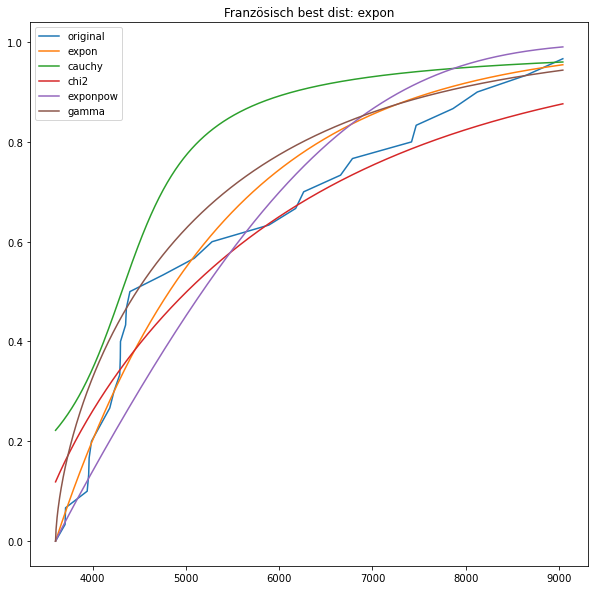

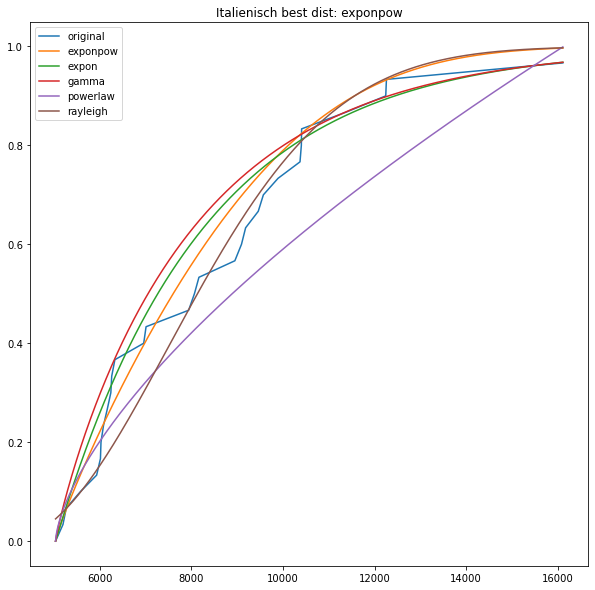

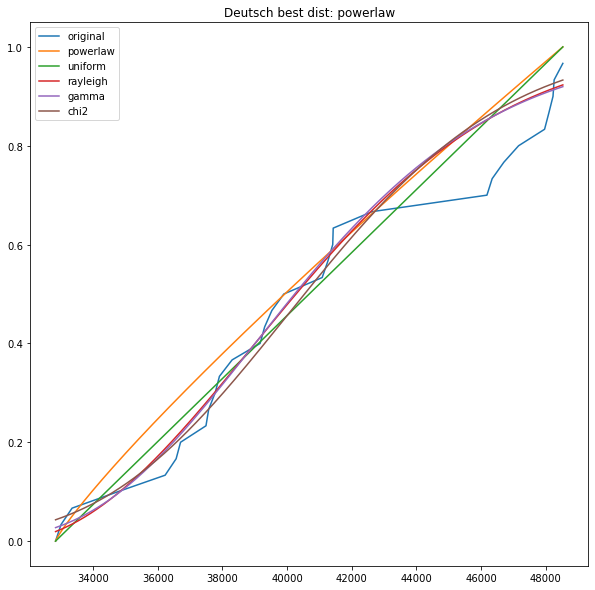

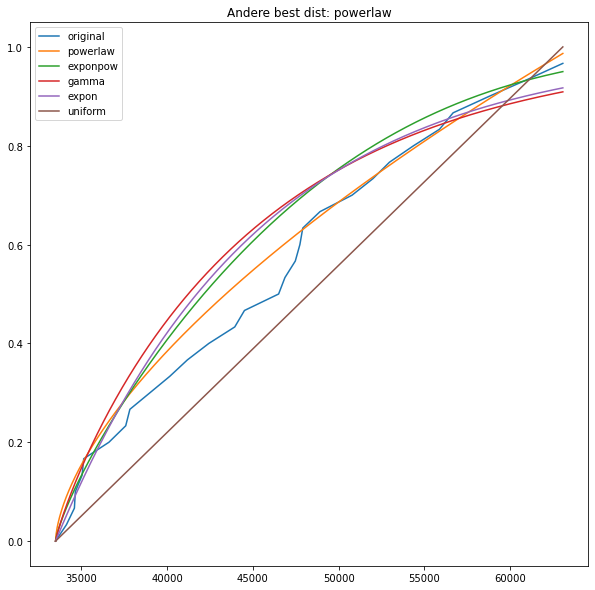

{'expon': (3603.0, 1758.0)}


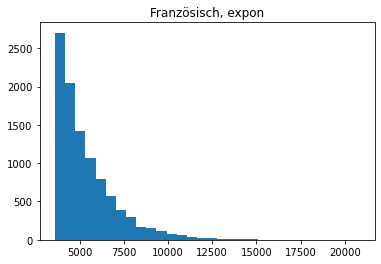

{'exponpow': (0.8782102394213684, 5031.999999999999, 5328.784763542875)}


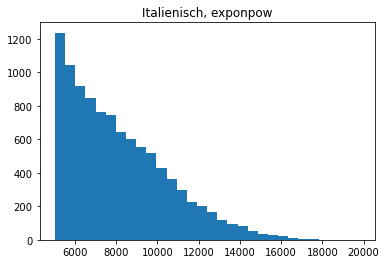

{'powerlaw': (0.8723781468086371, 32835.99999999999, 15696.224456815035)}


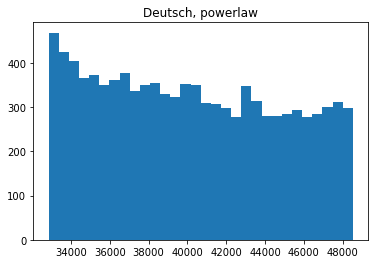

{'powerlaw': (0.6228172777400041, 33498.99999999999, 30206.546215367394)}


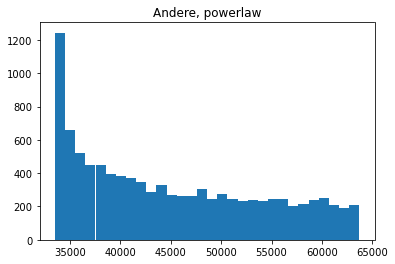

In [12]:
df_auswanderung = get_auswanderung()

dict_distributions = {}
for sprache in df_auswanderung.index.values:

    row_values = df_auswanderung.loc[sprache].dropna().values

    f = fitter.Fitter(row_values, timeout=60,distributions=fitter.get_common_distributions())
    f.fit()

    method = "sumsquare_error"
    dict_distributions[sprache] = f.get_best(method=method)

    display_distributions_cdf(f, row_values, sprache, method)

for sprache, dist in dict_distributions.items():
    obj = getattr(stats, list(dist.keys())[0])
    params = dist[list(dist.keys())[0]]

    if type(params) is dict:
        params = list(params.values())

    dist_vals = obj.rvs(size=10000, *params)

    plt.hist(dist_vals, bins=30)
    plt.title(sprache + ", " + str(list(dist.keys())[0]))
    plt.show()
    
dill.dump(dict_distributions, open("distributions_nach_sprache.pick", mode='wb'))